In [1]:
from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
from VariationalBayes.GammaParams import GammaParam
from VariationalBayes.ExponentialFamilies import \
    UnivariateNormalEntropy, MultivariateNormalEntropy, GammaEntropy, MVNPrior, UVNPrior, GammaPrior

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

import time

In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

simulate_data = False
prior_par = ModelParamsDict('Prior Parameters')

# Simulate data
N = 10     # observations per group
K = 10      # dimension of regressors
NG = 3000      # number of groups

# Generate data
NObs = NG * N
true_beta = np.array(range(K))
true_beta = true_beta - np.mean(true_beta)
true_y_info = 1.0

true_mu = 0.0
true_mu_info = 40.0
true_u = np.random.normal(true_mu, 1 / np.sqrt(true_mu_info), NG)

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
y_g_vec = np.array([ g for g in range(NG) for n in range(N) ])
true_mean = np.matmul(x_mat, true_beta) + true_u[y_g_vec]
y_vec = np.random.normal(true_mean, 1 / np.sqrt(true_y_info), NG * N)

prior_par.push_param(VectorParam('beta_mean', K, val=np.full(K, 0.0)))
prior_par.push_param(PosDefMatrixParam('beta_info', K, val=0.01 * np.eye(K)))

prior_par.push_param(ScalarParam('mu_mean', val=0.))
prior_par.push_param(ScalarParam('mu_info', val=0.5))

prior_par.push_param(ScalarParam('mu_info_shape', val=0.5))
prior_par.push_param(ScalarParam('mu_info_rate', val=0.5))

prior_par.push_param(ScalarParam('y_info_shape', val=0.0))
prior_par.push_param(ScalarParam('y_info_rate', val=10.0))

print N * NG

30000


In [3]:
lmm_par = ModelParamsDict('LMM Parameters')

lmm_par.push_param(MVNParam('beta', K))
lmm_par.push_param(UVNParam('mu'))
lmm_par.push_param(GammaParam('mu_info'))
lmm_par.push_param(GammaParam('y_info'))
lmm_par.push_param(UVNParamVector('u', NG))

lmm_par['beta'].mean.set(np.full(K, -0.2))
lmm_par['beta'].info.set(np.eye(K))

lmm_par['mu'].mean.set(0.2)
lmm_par['mu'].info.set(1.5)

lmm_par['mu_info'].shape.set(2.3)
lmm_par['mu_info'].rate.set(4.1)

lmm_par['y_info'].shape.set(2.4)
lmm_par['y_info'].rate.set(3.1)

lmm_par['u'].mean.set(np.full(NG, -0.1))
lmm_par['u'].info.set(np.full(NG, 0.8))

free_par_vec = lmm_par.get_free()

In [4]:
# Define moment parameters
moment_par = ModelParamsDict('Moment Parameters')
moment_par.push_param(VectorParam('e_beta', K))
moment_par.push_param(PosDefMatrixParam('e_beta_outer', K))
moment_par.push_param(ScalarParam('e_mu'))
moment_par.push_param(ScalarParam('e_mu2'))
moment_par.push_param(ScalarParam('e_mu_info'))
moment_par.push_param(ScalarParam('e_log_mu_info'))
moment_par.push_param(ScalarParam('e_y_info'))
moment_par.push_param(ScalarParam('e_log_y_info'))
moment_par.push_param(VectorParam('e_u', NG))
moment_par.push_param(VectorParam('e_u2', NG))

def set_moments(lmm_par, moment_par):
    moment_par['e_beta'].set(lmm_par['beta'].e())
    moment_par['e_beta_outer'].set(lmm_par['beta'].e_outer())
    moment_par['e_mu'].set(lmm_par['mu'].e())
    moment_par['e_mu2'].set(lmm_par['mu'].e_outer())
    moment_par['e_u'].set(lmm_par['u'].e())
    moment_par['e_u2'].set(lmm_par['u'].e_outer())
    moment_par['e_mu_info'].set(lmm_par['mu_info'].e())
    moment_par['e_log_mu_info'].set(lmm_par['mu_info'].e_log())
    moment_par['e_y_info'].set(lmm_par['y_info'].e())
    moment_par['e_log_y_info'].set(lmm_par['y_info'].e_log())
    
set_moments(lmm_par, moment_par)
init_moment_par = copy.deepcopy(moment_par)
init_par_vec = lmm_par.get_free()

# Moment indices.
moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

In [5]:
def ExpectedLogPriorMoments(e_beta, e_beta_outer,
                            e_mu, e_mu2,
                            e_mu_info, e_log_mu_info,
                            e_y_info, e_log_y_info,
                            prior_par):
    cov_beta = e_beta_outer - np.matmul(e_beta, e_beta.transpose())
    var_mu = e_mu2 - e_mu**2

    return \
        MVNPrior(prior_mean=prior_par['beta_mean'].get(),
                 prior_info=prior_par['beta_info'].get(),
                 e_obs=e_beta,
                 cov_obs=cov_beta) + \
        UVNPrior(prior_mean=prior_par['mu_mean'].get(),
                 prior_info=prior_par['mu_info'].get(),
                 e_obs=e_mu,
                 var_obs=var_mu) + \
        GammaPrior(prior_shape=prior_par['mu_info_shape'].get(),
                   prior_rate=prior_par['mu_info_rate'].get(),
                   e_obs=e_mu_info,
                   e_log_obs=e_log_mu_info) + \
        GammaPrior(prior_shape=prior_par['y_info_shape'].get(),
                   prior_rate=prior_par['y_info_rate'].get(),
                   e_obs=e_y_info,
                   e_log_obs=e_log_y_info)

def ExpectedLogPrior(moment_par, prior_par):
    e_beta = moment_par['e_beta'].get()
    e_beta_outer = moment_par['e_beta_outer'].get()

    e_mu = moment_par['e_mu'].get()
    e_mu2 = moment_par['e_mu2'].get()
    
    e_mu_info = moment_par['e_mu_info'].get()
    e_log_mu_info = moment_par['e_log_mu_info'].get()

    e_y_info = moment_par['e_y_info'].get()
    e_log_y_info = moment_par['e_log_y_info'].get()

    return ExpectedLogPriorMoments(e_beta, e_beta_outer,
                                   e_mu, e_mu2,
                                   e_mu_info, e_log_mu_info,
                                   e_y_info, e_log_y_info,
                                   prior_par)

ExpectedLogPrior(moment_par, prior_par)


-7.3491154669520355

In [6]:
def ExpectedRandomEffectLogLikelihoodMoments(e_mu, e_mu2,
                                             e_u, e_u2,
                                             e_mu_info, e_log_mu_info):
    return -0.5 * e_mu_info * np.sum(e_u2 - 2 * e_u * e_mu + e_mu2) + \
           0.5 * len(e_u) * e_log_mu_info


def ExpectedRandomEffectLogLikelihood(moment_par):
    e_mu = moment_par['e_mu'].get()
    e_mu2 = moment_par['e_mu2'].get()

    e_u = moment_par['e_u'].get()
    e_u2 = moment_par['e_u2'].get()

    e_mu_info = moment_par['e_mu_info'].get()
    e_log_mu_info = moment_par['e_log_mu_info'].get()
    
    return ExpectedRandomEffectLogLikelihoodMoments(
        e_mu, e_mu2, e_u, e_u2, e_mu_info, e_log_mu_info)

ExpectedRandomEffectLogLikelihood(moment_par)

-2904.9572253852934

In [7]:
class DataCache(object):
    def __init__(self, x_mat, y_vec, y_g_vec):
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.y_g_vec = y_g_vec
        self.y_t_y = np.dot(np.transpose(y_vec), y_vec)
        self.y_t_x = np.dot(np.transpose(y_vec), x_mat)
        self.x_t_x = np.dot(np.transpose(x_mat), x_mat)
        
        num_g = np.max(y_g_vec)
        k = x_mat.shape[1]
        num_g = np.max(y_g_vec) + 1
        self.num_g = num_g
        self.n_g = np.full(num_g, 0.0)
        self.y_sum_g = np.full(num_g, 0.0)
        self.x_sum_g = np.full((num_g, k), 0.0)
        for g in range(num_g):
            g_rows = np.array(y_g_vec) == g
            self.n_g[g] = np.sum(g_rows)
            self.y_sum_g[g] = np.sum(y_vec[g_rows])
            self.x_sum_g[g, :] = np.sum(x_mat[g_rows, :], 0)
    
data_cache = DataCache(x_mat, y_vec, y_g_vec)

In [8]:
def ExpectedDataLogLikelihoodMoments(e_beta, e_beta_outer,
                                     e_u, e_u2,
                                     e_y_info, e_log_y_info,
                                     data_cache):
    ll_global_term = \
        data_cache.y_t_y + \
        -2 * np.matmul(data_cache.y_t_x, e_beta) + \
        np.trace(np.matmul(data_cache.x_t_x, e_beta_outer)) 

    ll_group_term = np.sum(
        e_u2 * data_cache.n_g[g] + \
        -2 * e_u * data_cache.y_sum_g + \
        2 * e_u * np.matmul(data_cache.x_sum_g, e_beta))

    return -0.5 * e_y_info * (ll_global_term + ll_group_term) + 0.5 * len(y_vec) * e_log_y_info


def ExpectedDataLogLikelihood(data_cache, moment_par):
    e_beta = moment_par['e_beta'].get()
    e_beta_outer = moment_par['e_beta_outer'].get()
    
    e_u = moment_par['e_u'].get()
    e_u2 = moment_par['e_u2'].get()
    
    e_y_info = moment_par['e_y_info'].get()
    e_log_y_info = moment_par['e_log_y_info'].get()

    return ExpectedDataLogLikelihoodMoments(
        e_beta, e_beta_outer, e_u, e_u2, e_y_info, e_log_y_info, data_cache)


In [9]:
def ELBODataTermMoments(e_beta, e_beta_outer,
                        e_mu, e_mu2,
                        e_mu_info, e_log_mu_info,
                        e_y_info, e_log_y_info,
                        e_u, e_u2,
                        data_cache, prior_par):
    
    ll_data = ExpectedDataLogLikelihoodMoments(
        e_beta, e_beta_outer, e_u, e_u2, e_y_info, e_log_y_info, data_cache)
    if np.isnan(ll_data):
        print 'bad data log likelihood'
        return -np.inf

    ll_rf = ExpectedRandomEffectLogLikelihoodMoments(
        e_mu, e_mu2, e_u, e_u2, e_mu_info, e_log_mu_info)
    if np.isnan(ll_rf):
        print 'bad random effect log likelihood'
        return -np.inf

    e_log_prior = ExpectedLogPriorMoments(
        e_beta, e_beta_outer, e_mu, e_mu2,
        e_mu_info, e_log_mu_info, e_y_info, e_log_y_info, prior_par)
    if np.isnan(e_log_prior):
        print 'bad prior'
        return -np.inf

    return ll_data + ll_rf + e_log_prior

def ELBODataTerm(data_cache, moment_par, prior_par):
    e_beta = moment_par['e_beta'].get()
    e_beta_outer = moment_par['e_beta_outer'].get()

    e_u = moment_par['e_u'].get()
    e_u2 = moment_par['e_u2'].get()

    e_mu = moment_par['e_mu'].get()
    e_mu2 = moment_par['e_mu2'].get()
    
    e_mu_info = moment_par['e_mu_info'].get()
    e_log_mu_info = moment_par['e_log_mu_info'].get()

    e_y_info = moment_par['e_y_info'].get()
    e_log_y_info = moment_par['e_log_y_info'].get()
    
    return ELBODataTermMoments(
        e_beta, e_beta_outer, e_mu, e_mu2,
        e_mu_info, e_log_mu_info, e_y_info, e_log_y_info, e_u, e_u2,
        data_cache, prior_par)


ELBODataTerm(data_cache, moment_par, prior_par)

-125185.41258868125

In [10]:
class CoordinateAscentUpdater(object):
    def __init__(self, moment_par, data_cache, prior_par):
        self.moment_par = copy.deepcopy(moment_par)
        self.__data_cache = copy.deepcopy(data_cache)
        self.__prior_par = copy.deepcopy(prior_par)
        
        # Coefficient functions
        self.get_e_beta_coeff = grad(self.beta_e_log_data, 0)
        self.get_e_beta_outer_coeff = grad(self.beta_e_log_data, 1)
        self.get_e_mu_coeff = grad(self.mu_e_log_data, 0)
        self.get_e_mu2_coeff = grad(self.mu_e_log_data, 1)
        self.get_e_u_coeff = grad(self.u_e_log_data, 0)
        self.get_e_u2_coeff = grad(self.u_e_log_data, 1)
        self.get_e_mu_info_coeff = grad(self.mu_info_e_log_data, 0)
        self.get_e_log_mu_info_coeff = grad(self.mu_info_e_log_data, 1)
        self.get_e_y_info_coeff = grad(self.y_info_e_log_data, 0)
        self.get_e_log_y_info_coeff = grad(self.y_info_e_log_data, 1)

    # beta updates
    def beta_e_log_data(self, e_beta, e_beta_outer):
        self.moment_par['e_beta'].set(e_beta)
        self.moment_par['e_beta_outer'].set(e_beta_outer)
        return ELBODataTerm(self.__data_cache, self.moment_par, self.__prior_par)
    
    def update_beta(self):
        e_beta = self.moment_par['e_beta'].get()
        e_beta_outer = self.moment_par['e_beta_outer'].get()
        e_beta_coeff = self.get_e_beta_coeff(e_beta, e_beta_outer)
        e_beta_outer_coeff = self.get_e_beta_outer_coeff(e_beta, e_beta_outer)
        e_beta_outer_coeff = 0.5 * (e_beta_outer_coeff + e_beta_outer_coeff.transpose())
        new_cov_beta = -0.5 * np.linalg.inv(e_beta_outer_coeff)
        new_e_beta = np.matmul(new_cov_beta, e_beta_coeff)
        self.moment_par['e_beta'].set(new_e_beta)
        new_e_beta_outer = new_cov_beta + np.outer(new_e_beta, new_e_beta)
        new_e_beta_outer = 0.5 * (new_e_beta_outer + new_e_beta_outer.transpose())
        self.moment_par['e_beta_outer'].set(new_e_beta_outer)

    # mu updates
    def mu_e_log_data(self, e_mu, e_mu2):
        self.moment_par['e_mu'].set(e_mu)
        self.moment_par['e_mu2'].set(e_mu2)
        return ELBODataTerm(self.__data_cache, self.moment_par, self.__prior_par)
    
    def update_mu(self):
        e_mu = self.moment_par['e_mu'].get()
        e_mu2 = self.moment_par['e_mu2'].get()
        e_mu_coeff = self.get_e_mu_coeff(e_mu, e_mu2)
        e_mu2_coeff = self.get_e_mu2_coeff(e_mu, e_mu2)
        new_var_mu = -0.5 / e_mu2_coeff
        new_e_mu = new_var_mu * e_mu_coeff
        self.moment_par['e_mu'].set(new_e_mu)
        self.moment_par['e_mu2'].set(new_var_mu + new_e_mu**2)

    # u
    def u_e_log_data(self, e_u, e_u2):
        self.moment_par['e_u'].set(e_u)
        self.moment_par['e_u2'].set(e_u2)
        return ELBODataTerm(self.__data_cache, self.moment_par, self.__prior_par)
    
    def update_u(self):
        e_u = self.moment_par['e_u'].get()
        e_u2 = self.moment_par['e_u2'].get()
        e_u_coeff = self.get_e_u_coeff(e_u, e_u2)
        e_u2_coeff = self.get_e_u2_coeff(e_u, e_u2)
        new_var_u = -0.5 / e_u2_coeff
        new_e_u = new_var_u * e_u_coeff
        self.moment_par['e_u'].set(new_e_u)
        self.moment_par['e_u2'].set(new_var_u + new_e_u**2)

    # mu_info
    def mu_info_e_log_data(self, e_mu_info, e_log_mu_info):
        self.moment_par['e_mu_info'].set(e_mu_info)
        self.moment_par['e_log_mu_info'].set(e_log_mu_info)
        return ELBODataTerm(self.__data_cache, self.moment_par, self.__prior_par)
    
    def update_mu_info(self):
        e_mu_info = self.moment_par['e_mu_info'].get()
        e_log_mu_info = self.moment_par['e_log_mu_info'].get()
        new_rate = -1 * self.get_e_mu_info_coeff(e_mu_info, e_log_mu_info)
        new_shape = self.get_e_log_mu_info_coeff(e_mu_info, e_log_mu_info) + 1
        self.moment_par['e_mu_info'].set(new_shape / new_rate)
        self.moment_par['e_log_mu_info'].set(asp.special.digamma(new_shape) - np.log(new_rate))

    # y_info
    def y_info_e_log_data(self, e_y_info, e_log_y_info):
        self.moment_par['e_y_info'].set(e_y_info)
        self.moment_par['e_log_y_info'].set(e_log_y_info)
        return ELBODataTerm(self.__data_cache, self.moment_par, self.__prior_par)
    
    def update_y_info(self):
        e_y_info = self.moment_par['e_y_info'].get()
        e_log_y_info = self.moment_par['e_log_y_info'].get()
        new_rate = -1 * self.get_e_y_info_coeff(e_y_info, e_log_y_info)
        new_shape = self.get_e_log_y_info_coeff(e_y_info, e_log_y_info) + 1
        self.moment_par['e_y_info'].set(new_shape / new_rate)
        self.moment_par['e_log_y_info'].set(asp.special.digamma(new_shape) - np.log(new_rate))
    
    # Update and return the sum of absolute differences.
    def update(self):
        initial_moment_vec = self.moment_par.get_vector()
        self.update_beta()
        self.update_mu()
        self.update_mu_info()
        self.update_y_info()
        self.update_u()
        return np.sum(np.abs(initial_moment_vec - self.moment_par.get_vector()))

# Make sure it's doing something, or not, depending on whether you use
# the initial point or optimum.

# moment_par_test = copy.deepcopy(moment_par_opt)
# moment_par_test = copy.deepcopy(moment_par)

# ca_updater = CoordinateAscentUpdater(moment_par_test, data_cache, prior_par)
# print ca_updater.moment_par['e_beta']
# print ca_updater.moment_par['e_beta_outer']
# ca_updater.update_beta()
# print ca_updater.moment_par['e_beta']
# print ca_updater.moment_par['e_beta_outer']

# ca_updater = CoordinateAscentUpdater(moment_par_test, data_cache, prior_par)
# print ca_updater.moment_par['e_mu']
# print ca_updater.moment_par['e_mu2']
# ca_updater.update_mu()
# print ca_updater.moment_par['e_mu']
# print ca_updater.moment_par['e_mu2']

# ca_updater = CoordinateAscentUpdater(moment_par_test, data_cache, prior_par)
# print ca_updater.moment_par['e_u']
# print ca_updater.moment_par['e_u2']
# ca_updater.update_u()
# print ca_updater.moment_par['e_u']
# print ca_updater.moment_par['e_u2']

# ca_updater = CoordinateAscentUpdater(moment_par_test, data_cache, prior_par)
# print ca_updater.moment_par['e_mu_info']
# print ca_updater.moment_par['e_log_mu_info']
# ca_updater.update_mu_info()
# print ca_updater.moment_par['e_mu_info']
# print ca_updater.moment_par['e_log_mu_info']

# ca_updater = CoordinateAscentUpdater(moment_par_test, data_cache, prior_par)
# print ca_updater.moment_par['e_y_info']
# print ca_updater.moment_par['e_log_y_info']
# ca_updater.update_y_info()
# print ca_updater.moment_par['e_y_info']
# print ca_updater.moment_par['e_log_y_info']


In [11]:
ca_updater = CoordinateAscentUpdater(init_moment_par, data_cache, prior_par)

ca_time = time.time()
tol = 1e-9
delta = float('inf')
while delta > tol:
    delta = ca_updater.update()
    print delta
ca_time = time.time() - ca_time

ca_moment_par_opt = copy.deepcopy(ca_updater.moment_par)

print 'Coordinate ascent time (in minutes):'
print ca_time / 60.

4051.10053631
531.091089793
235.989315944
130.125527163
81.6493724621
56.2465657554
41.2827023168
31.6675112557
25.0841379383
20.35677168
16.8347601768
14.1328320596
12.0101977114
10.3096202744
8.92461384227
7.78080843842
6.82488189505
6.01772216989
5.33006416463
4.73962326666
4.22916386039
3.78516829735
3.39690109793
3.05573908561
2.75468402978
2.4880028049
2.25095810468
2.03960442513
1.85063173583
1.68124443334
1.52906670147
1.39206784854
1.26850290836
1.15686501223
1.05584691738
0.964309715827
0.881257217201
0.805814847124
0.737212163771
0.674768291933
0.617879723945
0.566010051755
0.518681283271
0.475466465146
0.435983388318
0.399889195116
0.366875740538
0.336665587147
0.309008534545
0.283678601688
0.260471394311
0.239201801077
0.219701971363
0.201819535172
0.1854160319
0.170365519873
0.156553342821
0.143875033012
0.132235333757
0.121547326457
0.111731649476
0.10271579786
0.094433494443
0.0868241240999
0.0798322240434
0.0734070239037
0.0675020301788
0.0620746502911
0.0570858520413


In [12]:
def ELBOEntropyTerm(lmm_par):
    return MultivariateNormalEntropy(lmm_par['beta'].info.get()) + \
           UnivariateNormalEntropy(lmm_par['mu'].info.get()) + \
           UnivariateNormalEntropy(lmm_par['u'].info.get()) + \
           GammaEntropy(shape=lmm_par['y_info'].shape.get(),
                        rate=lmm_par['y_info'].rate.get()) + \
           GammaEntropy(shape=lmm_par['mu_info'].shape.get(),
                        rate=lmm_par['mu_info'].rate.get())

def ELBO(data_cache, lmm_par, moment_par, prior_par):
    return ELBODataTerm(data_cache, moment_par, prior_par) + ELBOEntropyTerm(lmm_par)

print ELBODataTerm(data_cache, moment_par, prior_par)
print ELBOEntropyTerm(lmm_par)
print ELBO(data_cache, lmm_par, moment_par, prior_par)

-125185.412589
4607.77106411
-120577.641525


In [13]:
class KLWrapper(object):
    def __init__(self, lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, num_draws):
        self.__lmm_par_ad = copy.deepcopy(lmm_par)
        self.__prior_par_ad = copy.deepcopy(prior_par)
        self.__moment_par_ad = copy.deepcopy(moment_par)
        self.__data_cache = DataCache(x_mat, y_vec, y_g_vec)

    def KL(self, free_par_vec, verbose=False):
        self.__lmm_par_ad.set_free(free_par_vec)
        set_moments(self.__lmm_par_ad, self.__moment_par_ad)

        #print self.__lmm_par_ad
        kl = -ELBO(self.__data_cache,
                   self.__lmm_par_ad,
                   self.__moment_par_ad,
                   self.__prior_par_ad)[0]
        if verbose: print kl

        return kl


kl_wrapper = KLWrapper(lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, 20)
KLGrad = grad(kl_wrapper.KL)
KLHess = hessian(kl_wrapper.KL)
KLHessVecProd = hessian_vector_product(kl_wrapper.KL)  
print kl_wrapper.KL(free_par_vec)

120577.641525


In [14]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.KL(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num


Function time:
0.00109841823578
Grad time:
0.00899820327759
Hessian vector product time:
0.0229656934738


In [15]:

# Optimize.
vb_time = time.time()

print 'Running Newton Trust Region'
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.KL(par, verbose=True),
    trust_init, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd,
    tol=1e-6, options={'maxiter': 100, 'disp': True, 'gtol': 1e-6 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

print 'Done.'

print vb_time / 60

Running Newton Trust Region
120577.641525
69081.296886
57182.7835257
50679.4650681
44196.512277
33000.5732353
53396.4709205
28524.6458533
28187.2828909
26653.5730787
26069.7456315
25434.2730674
25317.3678823
24374.2595699
23292.0974862
23040.7341282
22996.8767184
20861.9852034
20659.9510221
20644.2832068
18292.6033732
17340.2867939
17274.7377395
17265.3669136
14194.1080456
13926.7045733
13897.5513091
13547.4918265
13544.924279
13541.0609554
12785.8865446
12775.8489556
12764.2738413
12648.3123272
12647.8802201
12647.6947434
12644.6634247
12627.6670627
12627.6279555
12627.5733751
12627.5733054
12626.2729343
12626.2715706
12626.2715575
12626.2446208
12626.2257034
12626.2257027
12626.2256674
12626.2250344
12626.2250342
12626.2250341
Optimization terminated successfully.
         Current function value: 12626.225034
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 50
         Hessian evaluations: 0
Done.
0.145019686222


In [16]:
moment_par_opt = copy.deepcopy(moment_par)
set_moments(lmm_par_opt, moment_par_opt)

# Make sure the coordinate ascent and trust region are close
moment_diff = np.sum(np.abs(ca_moment_par_opt.get_vector() - moment_par_opt.get_vector()))

print 'total moment difference: %f' % moment_diff
print 'trust region seconds: %f' % vb_time
print 'coordinate ascent seconds: %f' % ca_time

total moment difference: 0.000000
trust region seconds: 8.701181
coordinate ascent seconds: 1.879625


--------------- beta:

[-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
[-4.46355156 -3.49740965 -2.47656072 -1.50130708 -0.47085073  0.50231367
  1.49569755  2.5220754   3.48595369  4.4614083 ]
--------------- mu:

-0.00691267008813
0.0
--------------- mu info:

27.9995164139
40.0
--------------- y info:

1.00731500928
1.0


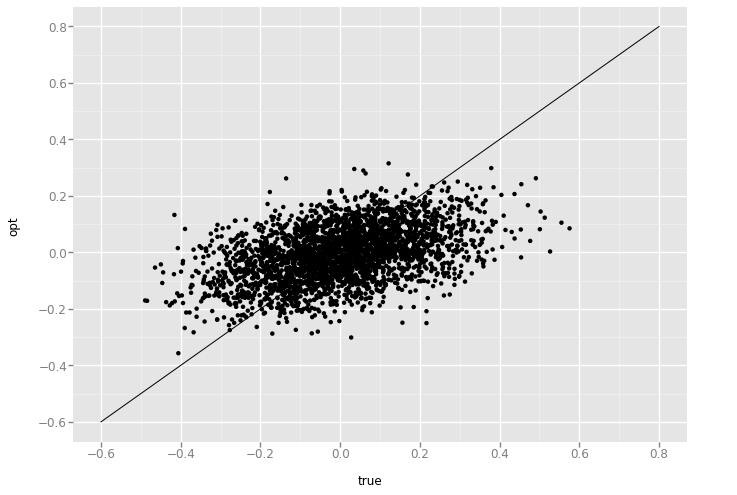

<ggplot: (8777068596713)>


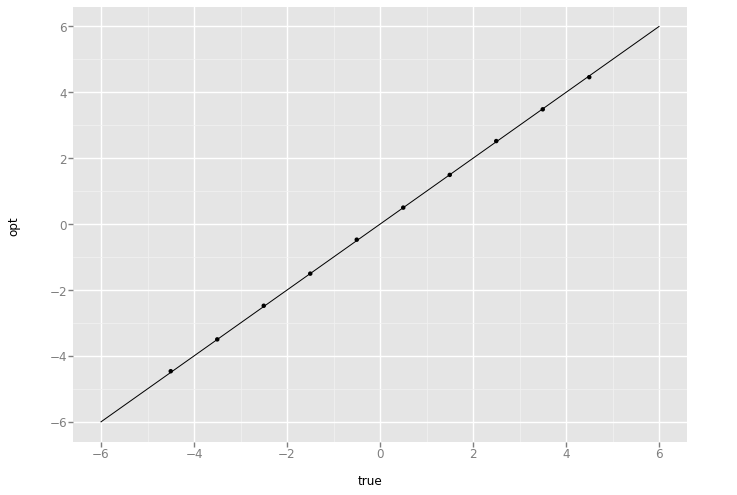

<ggplot: (8777068596697)>


In [17]:
# print(glmm_par_opt)
print '--------------- beta:\n'
print true_beta
print lmm_par_opt['beta'].e()

print '--------------- mu:\n'
print lmm_par_opt['mu'].e()[0]
print true_mu

print '--------------- mu info:\n'
print lmm_par_opt['mu_info'].e()[0]
print true_mu_info

print '--------------- y info:\n'
print lmm_par_opt['y_info'].e()[0]
print true_y_info


# Check the random effect estimates.  This requires simulated data.
from ggplot import *
import pandas as pd
%matplotlib inline

e_u = lmm_par_opt['u'].e()

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['beta'].e(), 'true': true_beta })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)


In [18]:
class MomentWrapper(object):
    def __init__(self, lmm_par, moment_par):
        self.__lmm_par_ad = copy.deepcopy(lmm_par)
        self.__moment_par = copy.deepcopy(moment_par)

    # Return a posterior moment of interest as a function of unconstrained parameters.
    def GetMoments(self, free_par_vec):
        self.__lmm_par_ad.set_free(free_par_vec)
        set_moments(self.__lmm_par_ad, self.__moment_par)
        return self.__moment_par.get_vector()
    
    def GetMomentParameters(self, free_par_vec):
        self.__glmm_par_ad.set_free(free_par_vec)
        set_moments(self.__glmm_par_ad, self.__moment_par)
        return self.__moment_par
    
moment_wrapper = MomentWrapper(lmm_par, moment_par)
MomentJacobian = jacobian(moment_wrapper.GetMoments)


In [19]:
# Slow, but probably faster than using CG if you want the covariance of many parameters.
hess_time = time.time()
print 'Calculating KL Hessian...'
kl_hess = KLHess(vb_opt.x)
hess_time =  time.time() - hess_time
elbo_hess = -kl_hess
print 'Done.'

print 'Hessian time (seconds): %f' % hess_time

Calculating KL Hessian...
Done.
Hessian time (seconds): 55.424865


In [20]:
hess_norm = np.sqrt(np.sum(kl_hess**2))
diag_norm = np.sqrt(np.sum(np.diag(kl_hess)**2))

# How diagonal is the Hessian?
print 'Proportion of the frobenius norm off the diagonal:'
print (hess_norm - diag_norm) / hess_norm

Proportion of the frobenius norm off the diagonal:
0.0290026502901


In [21]:
# jac_time = time.time()
# print 'Calculating the moment Jacobian...'
# moment_jac = MomentJacobian(vb_opt.x)
# jac_time =  time.time() - hess_time
# print 'Done.'

# print 'Jacobian time (seconds): %f' % jac_time

In [22]:
# lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

# prior_indices = copy.deepcopy(prior_par)
# prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

# vp_indices = copy.deepcopy(lmm_par_opt)
# vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))